# Heart Attack

Cardiovascular diseases, including heart attacks, are leading causes of morbidity and mortality worldwide. Early detection and intervention are crucial in reducing healthcare costs and improving patient outcomes. Hospitals and healthcare providers can leverage data analytics to predict heart attack risks, enabling proactive patient management and resource allocation.


**Healthcare facilities face challenges in:**

*  Early Identification: Detecting patients at high risk of heart attacks  
    before they occur.

*  Resource Optimization: Allocating medical resources efficiently to manage
    high-risk patients.

*  Personalized Care: Tailoring treatment plans based on individual risk
    profiles.


By analyzing this dataset, healthcare providers can develop predictive models to identify high-risk patients, optimize resource use, and personalize treatment strategies.


# *Heart Attack Dataset - Column Descriptions*

| *Column Name* | *Description* | *Data Type* | *Notes* |
|---------------|----------------|-------------|-----------------|
| *Age* | Age of the patient in years. | Integer | Helps assess age-related risk factors for heart attacks. |
| *Gender* | Patient’s gender (1 = Male, 0 = Female). | Categorical (0/1) | Gender differences may influence heart disease risk. |
| *Heart Rate* | Number of heartbeats per minute (bpm). | Integer | A high or irregular heart rate may indicate cardiovascular problems. |
| *SBP (Systolic Blood Pressure)* | Highest pressure in arteries when the heart beats (mm Hg). | Integer | High SBP is a strong predictor of heart attack risk. |
| *DBP (Diastolic Blood Pressure)* | Lowest pressure in arteries when the heart rests (mm Hg). | Integer | High DBP may indicate underlying cardiovascular issues. |
| *FBS (Fasting Blood Sugar)* | Blood sugar level after fasting (1 = >120 mg/dL, 0 = Normal). | Binary (0/1) | High FBS is a risk factor for heart disease and diabetes. |
| *CK-MB* | Creatine Kinase-MB enzyme level (ng/mL). | Float | An elevated CK-MB suggests possible heart muscle damage. |
| *Troponin* | Troponin enzyme level (ng/mL). | Float | A key biomarker for diagnosing heart attacks. High levels indicate cardiac damage. |
| *Result (Target Variable)* | Indicates heart attack occurrence (1 = Yes, 0 = No). | Binary (0/1) | Used as the target variable in predictive models. |


**Import Necessary Libraries**

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

 Read the Dataset

In [88]:
df = pd.read_csv('/content/Medicaldataset.csv')

# Explore the Data

**1- Basic Exploration**


*   print the first and last few rows for understanding the structure of the dataset.




In [89]:
df.head(3)

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative


In [90]:
df.tail(3)

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
1316,45,1,85,168,104,96.0,1.24,4.250,positive
1317,54,1,58,117,68,443.0,5.80,0.359,positive
1318,51,1,94,157,79,134.0,50.89,1.770,positive


In [91]:
print(f"Total Records : {df.shape[0]}")
print(f"Number of columns : {df.shape[1]}")

Total Records : 1319
Number of columns : 9


# Summary of Data

In [92]:
numerical_features = df.select_dtypes(include='number').columns
# There is only one categorical column
# changing the datatype for speed
df['Result'] = df['Result'].astype('category')
d_types = df.dtypes
null_ratio = (df.isnull().sum() / df.shape[0])*100
null_ratio = null_ratio.apply(lambda x: f'{x : .2f} %')
n_unique = df.nunique()
data_summary = pd.DataFrame({'Data_type': d_types, 'null_ratio': null_ratio,'No_of_unique':n_unique})
describe =df.describe().T
data_summary =pd.concat([data_summary,describe],axis=1)
data_summary.style.background_gradient(cmap ='Blues')

,Data_type,null_ratio,No_of_unique,count,mean,std,min,25%,50%,75%,max
Age,int64,0.00 %,75,1319.000000,56.191812,13.647315,14.000000,47.000000,58.000000,65.000000,103.000000
Gender,int64,0.00 %,2,1319.000000,0.659591,0.474027,0.000000,0.000000,1.000000,1.000000,1.000000
Heart rate,int64,0.00 %,79,1319.000000,78.336619,51.630270,20.000000,64.000000,74.000000,85.000000,1111.000000
Systolic blood pressure,int64,0.00 %,116,1319.000000,127.170584,26.122720,42.000000,110.000000,124.000000,143.000000,223.000000
Diastolic blood pressure,int64,0.00 %,73,1319.000000,72.269143,14.033924,38.000000,62.000000,72.000000,81.000000,154.000000
Blood sugar,float64,0.00 %,244,1319.000000,146.634344,74.923045,35.000000,98.000000,116.000000,169.500000,541.000000
CK-MB,float64,0.00 %,700,1319.000000,15.274306,46.327083,0.321000,1.655000,2.850000,5.805000,300.000000
Troponin,float64,0.00 %,352,1319.000000,0.360942,1.154568,0.001000,0.006000,0.014000,0.085500,10.300000
Result,category,0.00 %,2,nan,nan,nan,nan,nan,nan,nan,nan


**This dataset has no null values**

# Check for duplicated and delete it if there is .

In [93]:
#  Check for Duplicates and Drop Duplicates for train_df
duplicated_rows =df.duplicated().sum()
print(f"Number of duplicated rows is {duplicated_rows}")
# Drop duplicates
if duplicated_rows >0:
 df.drop_duplicates(inplace = True)
 print("Duplicates have been dropped .")
else :
  print("No duplicated row found .")

Number of duplicated rows is 0
No duplicated row found .


#  **Outliers**

 **Function for plotting boxplot to Numerical Coulumns.**

In [94]:
def plotly_boxplot(features):
  rows = int(np.ceil(len(numerical_features)/2))
  fig = make_subplots(rows=rows, cols=2)
  for i,column in enumerate(numerical_features):
   row = i // 2 + 1
   col = i % 2 + 1
   fig.add_trace(go.Box(y=df[column], name=column), row=row, col=col)

  fig.update_layout(title_text="Boxplot for observing Outliers", showlegend=False)
  fig.show()


In [95]:
plotly_boxplot(numerical_features)

**Outliers:**

*   Heart Rate, SBP, CK-MB, and Troponin: These features show the presence of
    outliers, indicated by data points lying beyond the whiskers of the boxplots. Outliers can significantly influence statistical analysis and model building.
*   Age, DBP, and FBS: These features appear to have fewer or no visible
    outliers, suggesting a more concentrated distribution of data within a typical range.

In [96]:
# Function for calculating outliers
def calculate_num_outliers(df,column):
   Q1 = df[column].quantile(0.25)
   Q3 = df[column].quantile(0.75)
   IQR = Q3-Q1
   lower_bound = Q1-1.5*IQR
   upper_bound = Q3+1.5*IQR
   outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
   outliers_no =len(outliers)
   if len(outliers)>0 :
    # replace the outlier from the above with the maximum value and from the lower
    # with the lower value.
    df[column] = df[column].clip(lower =lower_bound,upper = upper_bound )
   return outliers_no


   # function for handling outlier in categorical column
def calculate_cat_outliers(df, column):

    rare_threshold = 0.05
    frequency = df[column].value_counts(normalize=True)
    outliers = frequency[frequency < rare_threshold].index
    no_of_outliers = len(outliers)

    # If there are some outliers in the categorical columns (categories that are rarely occuring)
    # replace with the mode.
    if outliers.shape[0] > 0:
        df[column] = df[column].replace(outliers, df[column].mode()[0])
    return no_of_outliers


In [97]:
#  calculating outliers for numeric columns
numeric_outlier_df= pd.DataFrame(columns=['Column','Number of Outliers'])
no_of_numeric_outliers = []
numeric_columns= []
for column in numerical_features :
  outlier_number = calculate_num_outliers(df,column)
  no_of_numeric_outliers.append(outlier_number)
  numeric_columns.append(column)
numeric_outlier_df = pd.DataFrame({'Column':numeric_columns,'Number of Outliers':no_of_numeric_outliers})
numeric_outlier_df.style.background_gradient(cmap='Blues')

,Column,Number of Outliers
0,Age,7
1,Gender,0
2,Heart rate,30
3,Systolic blood pressure,32
4,Diastolic blood pressure,12
5,Blood sugar,92
6,CK-MB,205
7,Troponin,257


In [98]:
# Calculating Outliers for Categorical Column
calculate_cat_outliers(df,'Result')

0

**There is no outliers in Result Colunn**

#  Check the skeweness of numerical columns using histogram

The histograms are used to visually assess the distribution and skewness of each numerical feature. By examining the shape, center, and spread of the data, we can draw valuable conclusions about the data characteristics.

**Fuction** for histogram

In [99]:
def plotly_histplot(features):
  rows = int(np.ceil(len(features)/2))

  fig = make_subplots(rows=rows, cols=2,
                      subplot_titles=[f'{col}' for col in features])
  for i, column in enumerate(features):
    row = i // 2 + 1
    col = i % 2 + 1
    no_of_bins = int(np.ceil(np.sqrt(len(df[column]))))
    # Define colors for 'Yes' and 'No'
    colors = ['turquoise','violet']  # Choose your desired colors
    for j, result in enumerate(df['Result'].unique()):
           fig.add_trace(
              go.Histogram(
                          x=df[df['Result'] == result][column],
                          nbinsx=no_of_bins,
                          name=f"{column} - Result {result}",
                         # histnorm = 'percent',
                          marker=dict(color=colors[j])  # Use colors list with index j
                          ),
             row=row,
             col=col
                        )

  fig.update_layout(title_text='Histogram for numeric Columns Columns',height=row * 300, showlegend=True)
  fig.show()


In [100]:
plotly_histplot(numerical_features)

**Insights:**

*  **Age:**

   *  **Distribution:** Relatively normal distribution with a slight right skew .
   *  **Insight:** The dataset contains a diverse range of ages, with a higher
    concentration of individuals in younger age groups. This suggests age might be a contributing factor to heart attack risk, as heart disease is more prevalent in older populations.
*  **Heart Rate:**

   *  **Distribution:** Roughly normal distribution with a slight peak
   *  **Insight:** Most individuals have resting heart rates within a typical
    range, but variability exists. Abnormal heart rates (too high or too low) can be indicative of cardiovascular issues and might warrant further investigation.
*  **SBP (Systolic Blood Pressure):**

  *  **Distribution:** Moderate right skew with a longer tail on the higher end.
  *  **Insight:** While most individuals have systolic blood pressure within a
    certain range, some have significantly higher values, increasing their risk for cardiovascular issues. High SBP is a strong predictor of heart attack risk.
* **DBP (Diastolic Blood Pressure):**

   * **Distribution:** More symmetrical compared to SBP with a slight peak
    around 80-90 mmHg.
   * **Insight:** Less variability in diastolic blood pressure compared to
    systolic blood pressure. However, elevated DBP can still indicate underlying cardiovascular issues.
*  **FBS (Fasting Blood Sugar):**

    * **Distribution:** Bimodal pattern with two distinct peaks.
    * **Insight:** Presence of two distinct groups: those with normal fasting
    blood sugar levels and those with high levels (>120 mg/dL). High FBS is a risk factor for heart disease and diabetes, suggesting it could be a significant predictor of heart attack risk.
*  **CK-MB (Creatine Kinase-MB):**

    * **Distribution:** Highly right-skewed with a long tail towards high
    values.
    * **Insight:** Most individuals have low CK-MB levels, but some have
    significantly elevated levels, indicating potential heart muscle damage. Elevated CK-MB is a key indicator of heart attacks and should be closely monitored.
*  **Troponin:**

   * **Distribution:** Highly right-skewed with a long tail on the higher end,
    similar to CK-MB.
   * **Insight:** Most individuals have low Troponin levels, but some have
    significantly elevated levels, indicating potential heart muscle damage and increased risk of heart attacks. Troponin is a highly sensitive biomarker for heart attacks

# Result Column Pie Chart




In [101]:
fig = px.pie(df, names='Result', title='Result Ratio')
fig.update_traces(pull=[0, 0.05], selector=dict(type='pie'))
fig.show()

**Imbalanced Dataset:** The imbalanced nature of the 'Result' column can have implications for model training. Machine learning models might be biased towards predicting the majority class (no heart attack) and less accurate in identifying the minority class (heart attack).

#  Pair Plot
This visualization helps us understand:

Relationships between Features:

  *  **Scatter plots:** Each scatter shows the relationship between two numerical features.
  * **Histograms:** The diagonal of the pair plot displays histograms for each
    individual feature, showing their distribution and potential skewness.

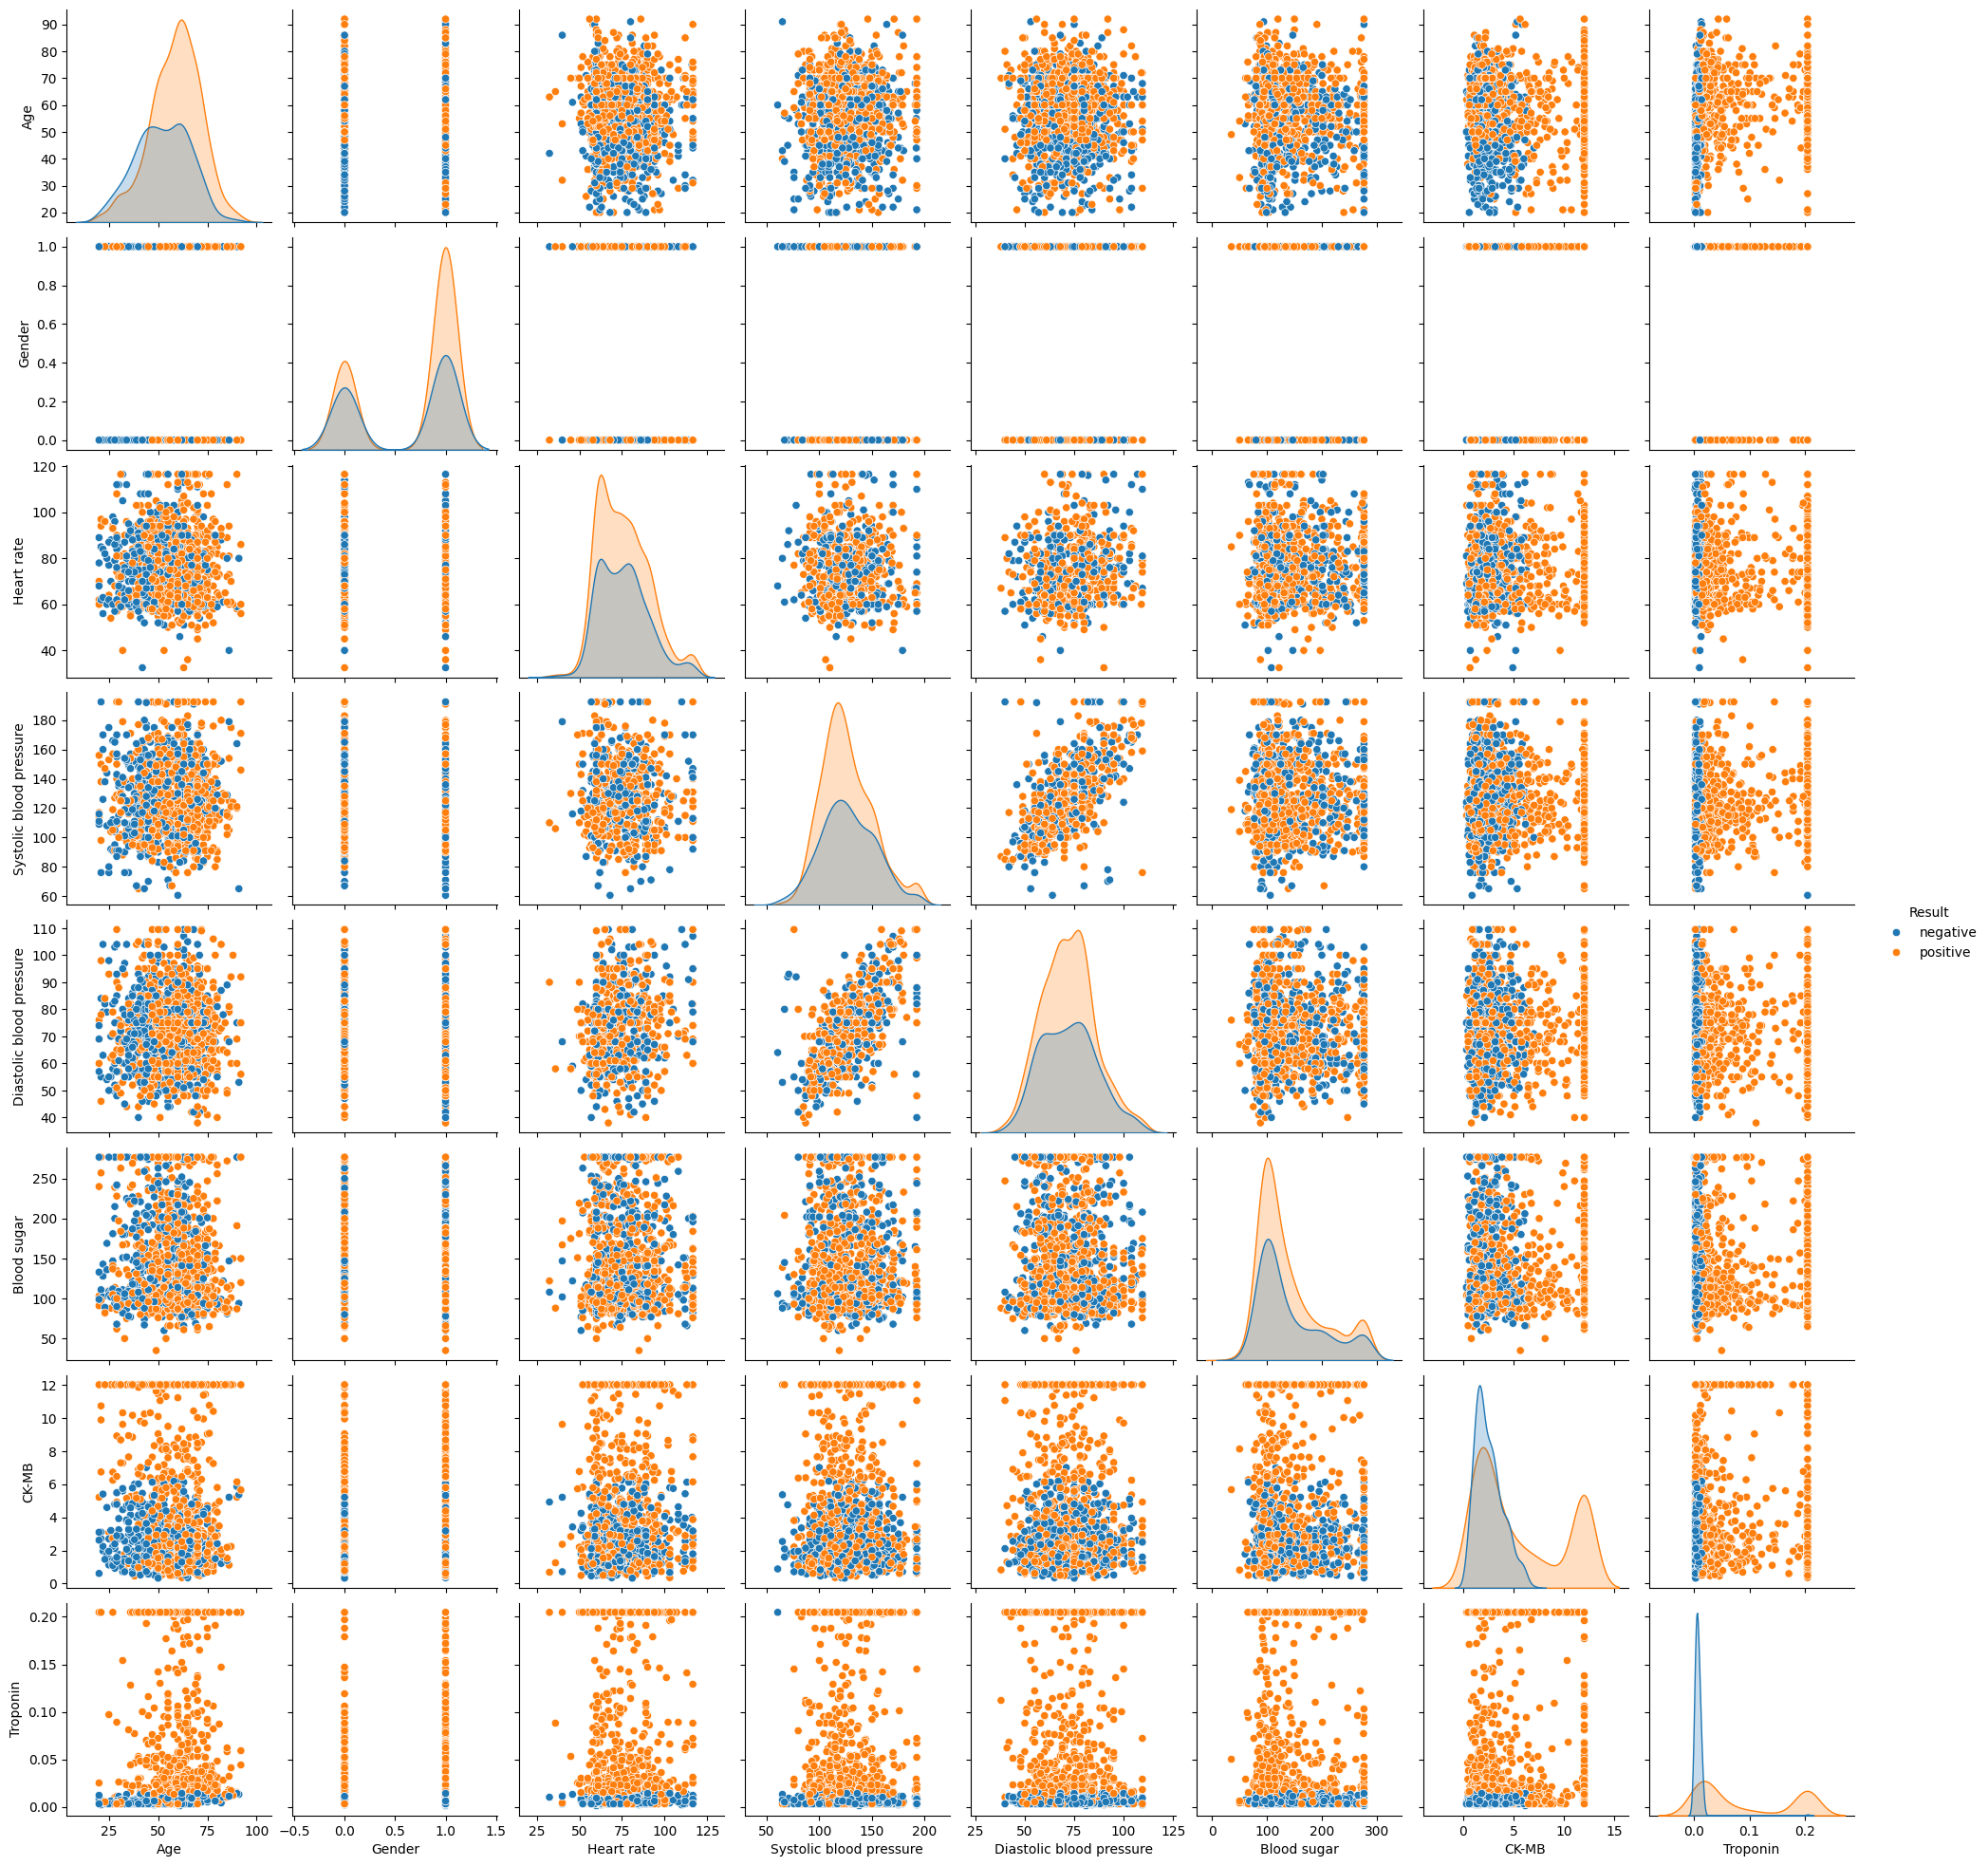

In [102]:
sns.pairplot(df,hue = 'Result')

 **Insights and Patterns:**

*  **Age and Heart Rate:** The scatter plot for Age vs. Heart Rate might show a
    slight negative correlation, indicating that heart rate tends to decrease with age.
* **SBP and DBP:** There's likely a strong positive correlation between SBP and
    DBP, as both are measures of blood pressure.
* **FBS and Result:** The scatter plot for FBS vs. Result might show that
    individuals with higher fasting blood sugar levels (FBS) are more likely to have heart attacks.
* **CK-MB and Troponin:** There's likely a strong positive correlation between
    CK-MB and Troponin, as both are indicators of heart muscle damage.

# Average Tropnin by Age

In [103]:

#  Binning Study Hours
# Define bin edges (adjust as needed)
bin_edges = [10, 20, 30, 40, 50, 60, 70,80,90,100]
# Create bins using pd.cut
# Feature Engineer
df['Age_binned'] = pd.cut(df['Age'], bins=bin_edges,
                                 labels=['10-20', '20-30', '30-40', '40-50', '50-60', '60-70','70-80','80-90','90-100'])
colmns = ['CK-MB','Troponin',
          'Diastolic blood pressure',
          'Systolic blood pressure',
           'Heart rate','Blood sugar']
fig = make_subplots(rows=3, cols=2,subplot_titles=[f'{col}' for col in colmns])

for i,col in enumerate(colmns):
#  Calculate Average Final Score for Each Bin
   row_no =i//2+1
   col_no = i%2+1
   average = df.groupby('Age_binned')[col].mean()
   fig.add_trace(go.Line(x=average.index, y=average.values, name=col), row=row_no, col=col_no)


   fig.update_layout(height =row_no *300)
   fig.update_xaxes(title_text='Age (Binned)')
   #fig.update_yaxes(title_text=f'Average {col}')
fig.update_layout(title_text='Average values of various physiological indicators by Age')
fig.show()


<ipython-input-103-8441cd6c8e78>:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




**Analysis and Insights:**

These line plots visualize the average values of various physiological indicators (CK-MB, Troponin, Diastolic BP, Systolic BP, Heart Rate, Blood Sugar) across different age groups. By observing the trends and patterns in these plots, we can draw several key insights:

**Age and Cardiac Markers (CK-MB, Troponin):**

  * Both CK-MB and Troponin, key indicators of heart muscle damage, generally   show an increasing trend with age.
  * This suggests a higher likelihood of cardiac issues, including heart
    attacks, in older individuals.
  * The steeper increase in Troponin levels in older age groups (60-70 and
    above) highlights a potentially higher risk of acute cardiac events in this demographic.
**Age and Blood Pressure (Diastolic, Systolic):**

  *  Systolic Blood Pressure exhibits a clear upward trend with age, indicating
    a gradual increase in blood pressure as individuals get older. This aligns with medical understanding of age-related hypertension.
  * Diastolic Blood Pressure also tends to increase with age, but the trend
    might be less pronounced compared to Systolic BP.
**Age and Heart Rate:**

  *  The line plot for Heart Rate might show a slight decline or a relatively
    stable trend with age.
  *  This could suggest that resting heart rate doesn't significantly change
    with age in the general population represented by this dataset.

**Age and Blood Sugar:**

  * The line plot for Blood Sugar might indicate a gradual increase with age,
    suggesting a potential link between aging and increased risk of developing diabetes or impaired glucose tolerance.
  * This finding aligns with the known association between age and metabolic
    changes that can affect blood sugar regulation.

* **Delete Age_binned:** Remove this feature from your dataset to avoid
    redundancy and potential multicollinearity issues.

In [104]:
df = df.drop('Age_binned',axis=1)

# Correlation Matrix

The correlation matrix provides valuable insights into the relationships between different features

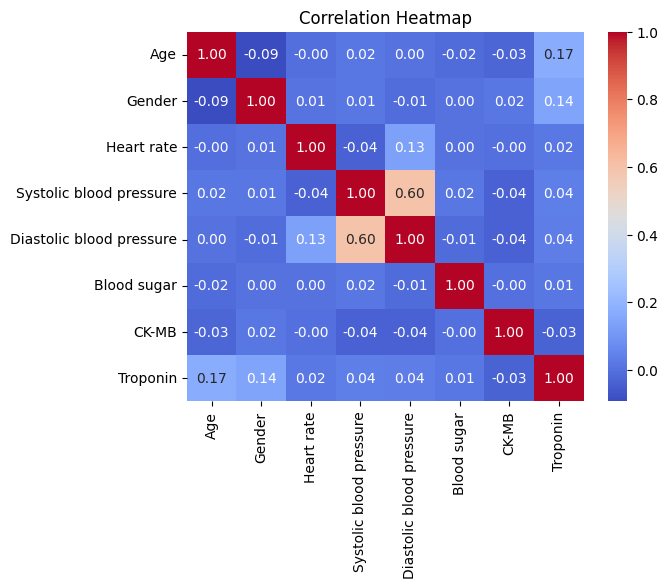

In [105]:
# Correlation Heatmap Correlation Among Features:
corr = df.drop('Result',axis =1).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

**Insights:**
 * **Blood Pressure:** Systolic and diastolic blood pressure are highly
    correlated and both tend to increase with age. These factors are likely to be important predictors of heart attack risk.
 * **Cardiac Markers:** CK-MB and Troponin are strongly correlated and could be
    useful indicators of potential heart muscle damage.
* **Age:** Age is moderately correlated with blood pressure, FBS, and heart
    attack risk, suggesting that it's an important factor to consider.
* **Gender:** Gender might not be a strong predictor of heart attack risk in
    this dataset based on the correlation matrix ,So I will delete it.

In [106]:
df = df.drop('Gender',axis=1)

In [107]:
# Encode Result colunn
df['Result'] = df['Result'].map({'Yes':1,'No':0})

In [108]:
# Save The cleaned encoded dataset
df.to_csv('Cleaned_Encoded_Heart_Attack.csv', index=False)